## Pitchers Like Me: Clustering Implementation

In [1]:
import numpy as np
import scipy
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import grid_search
from sklearn.pipeline import Pipeline
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import grid_search
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from sklearn.base import BaseEstimator, ClusterMixin

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# threshold for number of pitchers a pitcher must have thrown
pitch_threshold = 300

## Preprocessing

#### Read in 2018 Data

In [11]:
data = pd.read_csv('2018_updated_final.csv', encoding='latin1', low_memory=False)
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,barrel
0,FF,2018-04-08,93.5,-2.8990,6.0014,Giancarlo Stanton,519317,542960,strikeout,swinging_strike,...,8,7,8,8,7,7,8,Standard,Standard,NaN
1,CH,2018-04-08,86.4,-3.2825,5.6651,Giancarlo Stanton,519317,542960,NaN,called_strike,...,8,7,8,8,7,7,8,Standard,Standard,NaN
2,FF,2018-04-08,94.3,-2.3989,6.2012,Giancarlo Stanton,519317,542960,NaN,ball,...,8,7,8,8,7,7,8,Standard,Standard,NaN
3,FF,2018-04-08,93.5,-2.5249,6.2101,Giancarlo Stanton,519317,542960,NaN,foul,...,8,7,8,8,7,7,8,Standard,Standard,NaN
4,CH,2018-04-08,85.8,-3.4158,5.6694,Aaron Judge,592450,542960,grounded_into_double_play,hit_into_play,...,8,7,8,8,7,7,8,Strategic,Standard,0.0


In [4]:
data2017 = pd.read_csv('2017_updated_final.csv', encoding='latin1', low_memory=False)
data2017.head()

,pitcher,batter,num,b,s,o,start_tfs,start_tfs_zulu,stand,b_height,...,away_team_runs_when_up,bb_type,at_bat_id,in_strike_zone,outs_when_up.1,home_team_runs_when_up.1,away_team_runs_when_up.1,bb_type.1,at_bat_id.1,in_strike_zone.1
0,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,0,0,0,0,strike_out,1,0
1,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,0,0,0,0,strike_out,1,0
2,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,1,0,0,0,strike_out,1,1
3,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,1,0,0,0,strike_out,1,1
4,435221,488862,1,2,3,1,10807.0,2017-04-02T01:08:07Z,R,2-Jun,...,0,strike_out,1,0,0,0,0,strike_out,1,0


In [26]:
pitchers = data2017[['pitcher','pitcher_name']]
pitchers.head()

,pitcher,pitcher_name
0,435221,Brandon McCarthy
1,435221,Brandon McCarthy
2,435221,Brandon McCarthy
3,435221,Brandon McCarthy
4,435221,Brandon McCarthy


Desired Fields:
Type
–– Perceived Speed
–– Release Angle
–– Release Direction
–– Spin Axis
–– Release Position X
–– Release Position Y
–– Release Position Z
–– Extension
–– Vertical Break
–– Vertical Break Induced
–– Horizontal Break
–– Location X
–– Location Y
–– Location Z
–– Zone Speed
–– Effective Velocity
–– Vertical Approach Angle
–– Horizontal Approach Angle
–– Zone Time

#### Preprocess the data and keep only those columns requested above (from the email). Some are missing because they don't seem to exist

In [12]:
keep = ['pitcher', 'pitch_type', 'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
        'release_extension', 'plate_x', 'plate_z', 'effective_speed', 'p_throws']
data = data[keep]
data = data.fillna(data.mean())

In [13]:
data.head()

,pitcher,pitch_type,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,release_extension,plate_x,plate_z,effective_speed,p_throws
0,542960,FF,2415.0,-2.8990,54.6681,6.0014,5.831,0.2211,3.3739,92.360,R
1,542960,CH,2082.0,-3.2825,54.3302,5.6651,6.169,0.6790,2.0509,86.275,R
2,542960,FF,2367.0,-2.3989,54.4215,6.2012,6.078,1.2735,1.9941,93.769,R
3,542960,FF,2331.0,-2.5249,54.5184,6.2101,5.981,-0.3819,2.6193,92.596,R
4,542960,CH,2039.0,-3.4158,54.8703,5.6694,5.629,-0.3398,1.6989,84.703,R


In [14]:
throws = data['p_throws']
throws = [1 if throws[i] == 'R' else 0 for i in range(len(throws))]
data['p_throws'] = throws

In [15]:
data.head()

,pitcher,pitch_type,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,release_extension,plate_x,plate_z,effective_speed,p_throws
0,542960,FF,2415.0,-2.8990,54.6681,6.0014,5.831,0.2211,3.3739,92.360,1
1,542960,CH,2082.0,-3.2825,54.3302,5.6651,6.169,0.6790,2.0509,86.275,1
2,542960,FF,2367.0,-2.3989,54.4215,6.2012,6.078,1.2735,1.9941,93.769,1
3,542960,FF,2331.0,-2.5249,54.5184,6.2101,5.981,-0.3819,2.6193,92.596,1
4,542960,CH,2039.0,-3.4158,54.8703,5.6694,5.629,-0.3398,1.6989,84.703,1


#### Group-by and aggregate by mean value for each dimension across each pitch type and pitcher

In [16]:
data['ncount'] = 1
keys = {'release_spin_rate': np.mean, 'release_pos_x': np.mean, 'release_pos_y': np.mean, 'release_pos_z': np.mean,
        'release_extension': np.mean, 'plate_x': np.mean, 'plate_z': np.mean, 
        'effective_speed': np.mean, 'p_throws': np.mean, 'ncount': np.sum}

In [17]:
X = data.groupby(['pitch_type', 'pitcher'], as_index=False).agg(keys)
X = X[X['ncount'] > pitch_threshold]
X.head()

,pitch_type,pitcher,plate_z,release_spin_rate,release_extension,ncount,p_throws,release_pos_y,plate_x,effective_speed,release_pos_z,release_pos_x
8,CH,425844,1.564012,1747.221519,5.906290,486,1.0,54.595012,-0.484788,86.160481,6.187645,-1.223190
12,CH,430935,1.615048,1650.411378,6.307349,427,0.0,54.191291,0.429624,83.203913,6.236578,2.603454
14,CH,433587,1.935728,1711.260884,6.156110,428,1.0,54.343393,-0.322914,84.892963,5.939094,-2.231967
31,CH,448306,1.779267,1671.574118,6.705294,425,1.0,53.793941,-0.487487,84.116419,5.634798,-2.487900
44,CH,453281,1.776442,1507.679630,6.273796,540,0.0,54.226183,0.536807,77.692594,5.643504,2.694541


In [18]:
del X['ncount']
X.head()

,pitch_type,pitcher,plate_z,release_spin_rate,release_extension,p_throws,release_pos_y,plate_x,effective_speed,release_pos_z,release_pos_x
8,CH,425844,1.564012,1747.221519,5.906290,1.0,54.595012,-0.484788,86.160481,6.187645,-1.223190
12,CH,430935,1.615048,1650.411378,6.307349,0.0,54.191291,0.429624,83.203913,6.236578,2.603454
14,CH,433587,1.935728,1711.260884,6.156110,1.0,54.343393,-0.322914,84.892963,5.939094,-2.231967
31,CH,448306,1.779267,1671.574118,6.705294,1.0,53.793941,-0.487487,84.116419,5.634798,-2.487900
44,CH,453281,1.776442,1507.679630,6.273796,0.0,54.226183,0.536807,77.692594,5.643504,2.694541


In [19]:
pitch_types, pitchers = X.pitch_type.unique(), X.pitcher.unique()
pitch_types

array(['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 'KN', 'SI', 'SL'],
      dtype=object)

#### Normalize the data to 0 mean, unit variance columns

In [20]:
scaler = StandardScaler()
X.iloc[:,2:] = scaler.fit_transform(X.iloc[:,2:])
X.head()

,pitch_type,pitcher,plate_z,release_spin_rate,release_extension,p_throws,release_pos_y,plate_x,effective_speed,release_pos_z,release_pos_x
8,CH,425844,-1.731765,-1.885026,-0.247486,0.635418,0.251314,-1.741378,-0.469703,0.679442,-0.238998
12,CH,430935,-1.606357,-2.251312,0.655892,-1.573768,-0.658185,1.270696,-0.986197,0.780478,1.701230
14,CH,433587,-0.818382,-2.021085,0.315230,0.635418,-0.315530,-1.208167,-0.691130,0.166234,-0.750479
31,CH,448306,-1.202838,-2.171242,1.552255,0.635418,-1.553331,-1.750270,-0.826788,-0.462079,-0.880245
44,CH,453281,-1.209780,-2.791344,0.580315,-1.573768,-0.579580,1.623758,-1.948990,-0.444103,1.747414


## Generate the Cluster Assignments

### K-Means

In [21]:
cluster_limit = 15
models = {}
for pitch_type in pitch_types:
    models[pitch_type] = {}

#### In the plots below, the optimal number of clusterings should be at the elbow of the curve

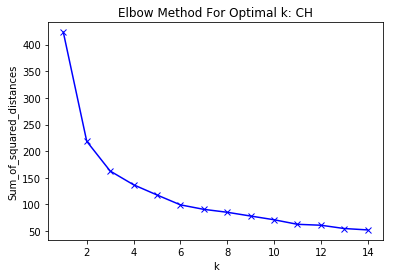

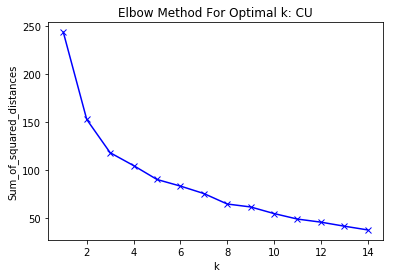

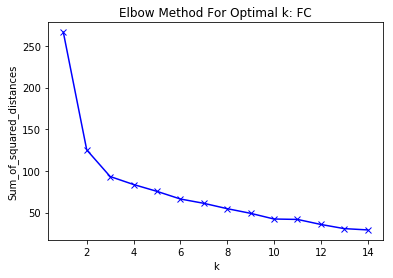

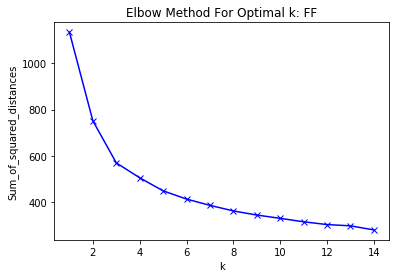

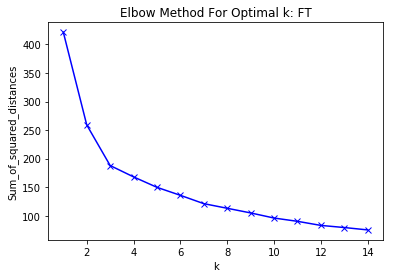

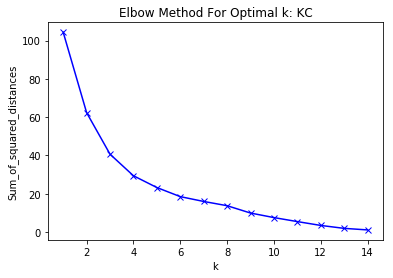

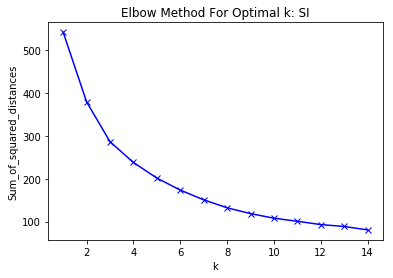

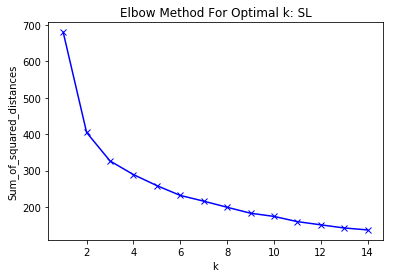

In [22]:
K = range(1, cluster_limit)
for pitch_type in pitch_types:
    group = X[X['pitch_type'] == pitch_type]
    group = group.drop(['pitch_type','pitcher'], 1)
    if group.shape[0] > cluster_limit:
        sum_of_squared_distances = []
        for k in K:
            km = KMeans(n_clusters=k)
            km = km.fit(group)
            models[pitch_type][k] = km
            sum_of_squared_distances.append(km.inertia_)
        plt.plot(K, sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title('Elbow Method For Optimal k: ' + pitch_type)
        plt.show()

#### The clustering models by pitch type are stored in the means dict below (kmeans[pitch_type] returns a model to fit on new data)

In [23]:
kmeans = {}
kmeans['CH'] = models['CH'][5]
kmeans['CU'] = models['CU'][7]
kmeans['FC'] = models['FC'][3]
kmeans['FF'] = models['FF'][5]
kmeans['FT'] = models['FT'][7]
kmeans['KC'] = models['KC'][4]
kmeans['SI'] = models['SI'][8]
kmeans['SL'] = models['SL'][6]
kmeans

{'CH': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'CU': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'FC': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'FF': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'FT': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 'KC': KMeans(algorithm='auto'

### GridSearch clustering pipeline

In [159]:
pipelines = {}
cluster_limit = 10

In [150]:
for pitch_type in pitch_types:
    group = X[X['pitch_type'] == pitch_type]
    group = group.drop(['pitch_type','pitcher'], 1)
    if group.shape[0] > cluster_limit:
        parameters = {'n_clusters': [i for i in range(1, cluster_limit)]}
        km = KMeans()
        grid = grid_search.GridSearchCV(km, parameters)
        pipeline = Pipeline([('clusterer', grid)])
        pipeline.fit(group)
        pipelines[pitch_type] = pipeline
pipelines

{'CH': Pipeline(memory=None,
      steps=[('clusterer', GridSearchCV(cv=None, error_score='raise',
        estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
        fit_params={}, iid=True, n_jobs=1,
        param_grid={'n_clusters': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
        pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0))]),
 'CU': Pipeline(memory=None,
      steps=[('clusterer', GridSearchCV(cv=None, error_score='raise',
        estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
        fit_params={}, iid=True, n_jobs=1,
        param_grid={'n_clusters': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
        pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0))]),
 'FC': Pipeline(memory=None,
 

### Evidence Accumulation Clustering (EAC)
#### Cluster data many times, record labels on each, see # times pair appears. First cluster data many times with KMeans, then apply hierarchical clustering on coassociation matrix. The hierarchical clustering in this case is same as finding minimum spanning tree.

In [176]:
def create_coassociation_matrix(labels):
    rows, cols = [], []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0] # where instead of which in R
        for index1 in indices: # for each pair of samples with same label, record both positions
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
    data = np.ones((len(rows),)) # data has value 1 for every time two samples were listed together
    return csr_matrix((data, (rows, cols)), dtype='float')

# Create EAC clustering algorithm fitting scikit interface
class EAC(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusterings=25, cut_threshold=0.5, n_clusters_range=(3,cluster_limit)):
        self.n_clusterings = n_clusterings
        self.cut_threshold = cut_threshold
        self.n_clusters_range = n_clusters_range
    
    def fit(self, X, y=None):
        C = sum((create_coassociation_matrix(self._single_clustering(X)) 
                 for i in range(self.n_clusterings)))
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        self.n_components, self.labels_ = connected_components(mst)
        return self
    
    def _single_clustering(self, X):
        n_clusters = np.random.randint(*self.n_clusters_range)
        km = KMeans(n_clusters=n_clusters)
        return km.fit_predict(X)

In [177]:
eac = {}

In [178]:
for pitch_type in pitch_types:
    group = X[X['pitch_type'] == pitch_type]
    group = group.drop(['pitch_type','pitcher'], 1)
    if group.shape[0] > cluster_limit:
        pipeline = Pipeline([('clusterer', EAC())])
        pipeline.fit(group)
        nEAC = pipeline.named_steps['clusterer'].n_clusterings
        print('{} clusters were found'.format(nEAC))
        eac[pitch_type] = pipeline
eac

10 clusters were found
10 clusters were found
10 clusters were found
10 clusters were found
10 clusters were found
10 clusters were found
10 clusters were found
10 clusters were found


{'CH': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_range=(3, 10)))]),
 'CU': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_range=(3, 10)))]),
 'FC': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_range=(3, 10)))]),
 'FF': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_range=(3, 10)))]),
 'FT': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_range=(3, 10)))]),
 'KC': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_range=(3, 10)))]),
 'SI': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_range=(3, 10)))]),
 'SL': Pipeline(memory=None,
      steps=[('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_ran

## Generating Predictive Cluster Assignments

#### KMeans prediction example

In [31]:
pitch_type = 'FF'
group = X[X['pitch_type'] == pitch_type]
pitch = group.pitcher
group = group.drop(['pitch_type','pitcher'], 1)
labels = kmeans[pitch_type].predict(group)
labels

array([2, 3, 1, 0, 3, 4, 4, 1, 1, 0, 2, 4, 4, 4, 3, 4, 1, 4, 0, 4, 0, 2,
       2, 4, 2, 1, 3, 2, 3, 4, 3, 4, 3, 3, 0, 1, 3, 1, 3, 3, 3, 1, 1, 2,
       3, 0, 0, 3, 3, 4, 3, 3, 3, 3, 1, 3, 4, 2, 2, 4, 4, 2, 4, 4, 0, 4,
       4, 2, 3, 3, 4, 4, 0, 4, 4, 1, 3, 0, 0, 4, 2, 3, 3, 0, 4, 3, 1, 3,
       2, 0, 4, 2, 1, 4, 3, 3, 4, 4, 4, 4, 2, 1, 0, 2, 3, 2, 4, 0, 4, 3,
       4, 1, 4, 4, 0, 4, 3, 3, 3, 1, 0, 0, 2, 2, 3, 0, 4, 0, 4, 0, 0, 0,
       4, 2, 0, 4, 0, 3, 0, 2, 4, 1, 0, 1, 3, 0, 4, 4, 0, 3, 0, 4, 0, 0,
       3, 0, 3, 0, 4, 1, 2, 4, 4, 4, 2, 4, 0, 2, 3, 0, 1, 4, 1, 4, 4, 0,
       4, 0, 3, 4, 4, 1, 2, 0, 4, 0, 4, 0, 3, 0, 2, 2, 3, 4, 0, 4, 4, 4,
       4, 1, 1, 4, 4, 1, 4, 3, 0, 4, 2, 4, 0, 3, 0, 1, 4, 3, 0, 4, 2, 2,
       2, 0, 0, 0, 0, 4], dtype=int32)

In [32]:
result = pd.DataFrame()
result['pitcher'], result['cluster'] = pitch, labels
result = pd.merge(result, pitchers)
result.head()

,pitcher,cluster,pitcher_name
0,407822,2,Jorge De La Rosa
1,407822,2,Jorge De La Rosa
2,407822,2,Jorge De La Rosa
3,407822,2,Jorge De La Rosa
4,407822,2,Jorge De La Rosa


In [39]:
clusters = pd.DataFrame()
for pitch_type in kmeans:
    group = X[X['pitch_type'] == pitch_type]
    pitch = group.pitcher
    group = group.drop(['pitch_type','pitcher'], 1)
    labels = kmeans[pitch_type].predict(group)
    result = pd.DataFrame()
    result['pitcher'], result['cluster'] = pitch, labels
    result = pd.merge(result, pitchers)
    result['pitch_type'] = pitch_type
    clusters = clusters.append(result)
clusters.head()

,pitcher,cluster,pitcher_name,pitch_type
0,407822,2,Jorge De La Rosa,FF
1,407822,2,Jorge De La Rosa,FF
2,407822,2,Jorge De La Rosa,FF
3,407822,2,Jorge De La Rosa,FF
4,407822,2,Jorge De La Rosa,FF


In [40]:
clusters.to_csv('pitcher_clusters.csv', index=False)